# EuroSAT Dataset Applying Custom CNN 

In [46]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
import platform
import psutil
import random
import cv2
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
from PIL import ImageOps

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.models as models

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur

from tqdm.notebook import tqdm
from tqdm import tqdm

from torchinfo import summary
from torchsummary import summary

from collections import OrderedDict

from tabulate import tabulate

### Configuration

In [47]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [48]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [49]:
data_dir = "/kaggle/input/eurosat-dataset/EuroSAT"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
     if not class_name.lower().endswith(('.csv', '.json')):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame(
    {
        "file_path": file_paths,
        "label": labels,
        }
    )
df = df.sample(frac=1).reset_index(drop=True)

### Class Count & Bar Plot

class: SeaLake --> count: 3000
class: HerbaceousVegetation --> count: 3000
class: Forest --> count: 3000
class: AnnualCrop --> count: 3000
class: Residential --> count: 3000
class: Highway --> count: 2500
class: Industrial --> count: 2500
class: PermanentCrop --> count: 2500
class: River --> count: 2500
class: Pasture --> count: 2000


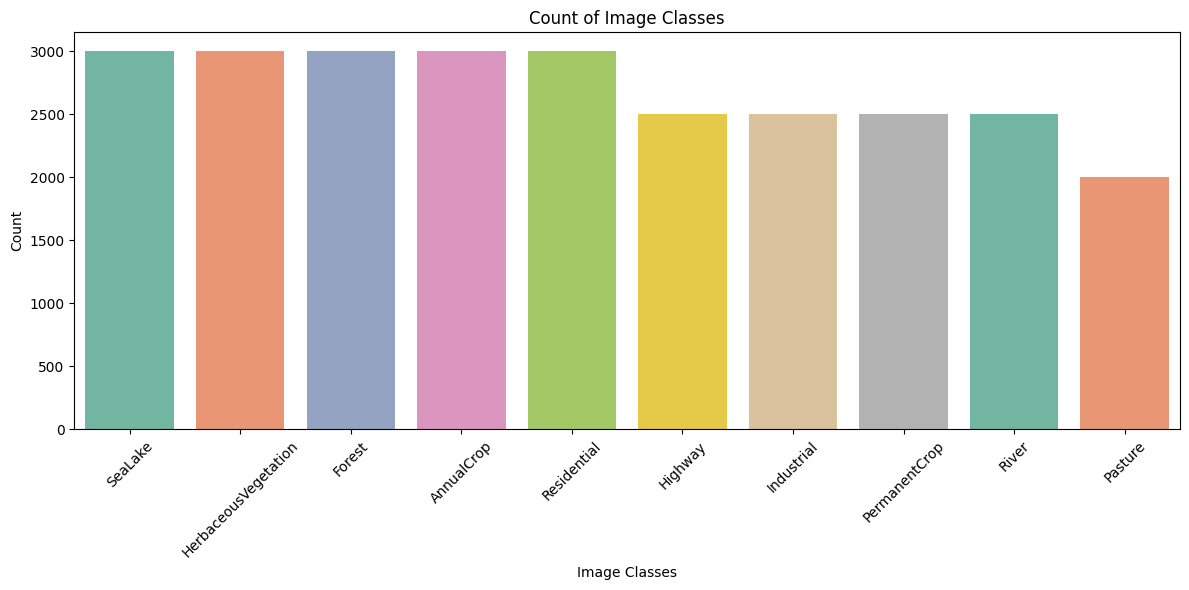

In [50]:
# Class count and Bar plot
class_count = df['label'].value_counts()

for class_name , count in class_count.items():
    print(f"class: {class_name} --> count: {count}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='Set2')
plt.title('Count of Image Classes')
plt.xlabel('Image Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sample Images From Each Classes

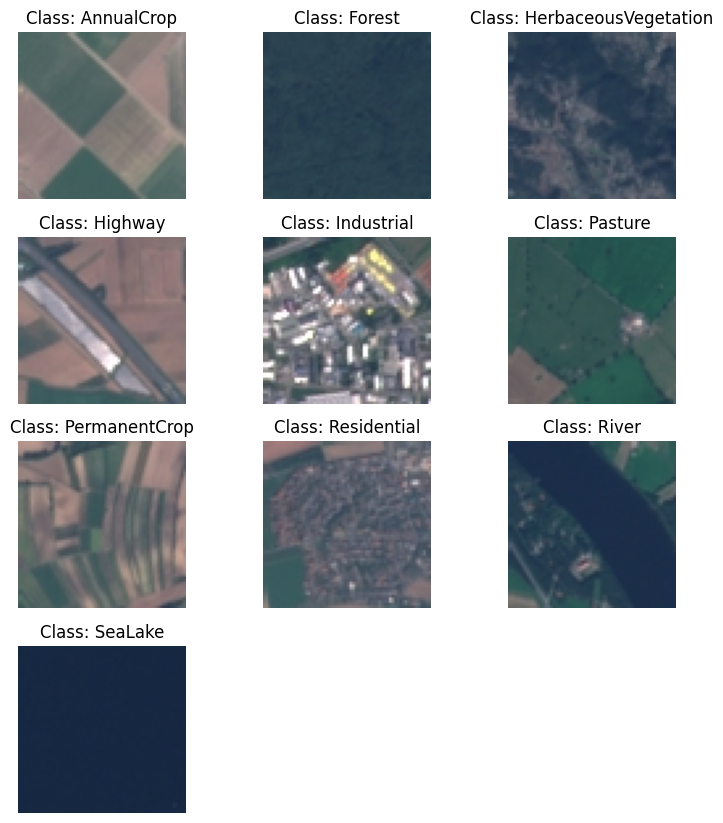

In [51]:
# Get class names
class_names = sorted(df['label'].unique())

# set up figure
plt.figure(figsize=(3 * 2.5, len(class_names) / 3  * 2.5))

# One sample image per class
for i, class_name in enumerate(class_names):
    try:
        # get sample for this class
        path = df[df['label'] == class_name]['file_path'].sample(1).values[0]
        with Image.open(path) as img:
            plt.subplot(int(len(class_names) / 3)+1, 3, i+1)
            plt.imshow(img)
            plt.title(f"Class: {class_name}")
            plt.axis('off')
    except Exception as e:
        print(f"Error reading image {path}: {e}")
        continue


plt.tight_layout()
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [52]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30,
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50,
                                            stratify=temp_dataframe['label'], random_state=42)

In [53]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  18900
Validation Data:  4050
Test Data:  4050
-------------------------------------------
Total amounts of data in the dataset:  27000


In [54]:

class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                   Count
--------------------  -------
Residential              2100
SeaLake                  2100
AnnualCrop               2100
Forest                   2100
HerbaceousVegetation     2100
PermanentCrop            1750
Industrial               1750
Highway                  1750
River                    1750
Pasture                  1400

Validation Dataset
Class                   Count
--------------------  -------
AnnualCrop                450
SeaLake                   450
Residential               450
HerbaceousVegetation      450
Forest                    450
Highway                   375
Industrial                375
PermanentCrop             375
River                     375
Pasture                   300

Test Dataset
Class                   Count
--------------------  -------
SeaLake                   450
AnnualCrop                450
Forest                    450
HerbaceousVegetation      450
Residential               450
PermanentCrop         

label mapping

In [55]:
classes = sorted(df['label'].unique())
label_map = {class_name: i for i, class_name in enumerate(classes)}
print(label_map)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


### Device Variable

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [57]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Integrate Class-weight Loss

In [58]:
# Extract class labels from your training dataframe
train_labels = train_dataframe['label'].map(label_map).values
num_classes = len(classes)

# print(np.unique(train_labels))
# print(np.arange(num_classes))

# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

### Dataset Class, Dataloader and Transform

In [59]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.classes = sorted(dataframe['label'].unique())
        self.label_map = label_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)



In [60]:
train_batch = 64
val_batch = 8

def data_transfrom():
    size = 224
    normalize = transforms.Compose([
            transforms.Resize((size,size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])

    train_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ])


    train_dataset = ImageDataset (
        train_dataframe,
        train_transform,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=4)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=4)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=4)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

### Convolutional Neural Netwirk (G7CNN)

In [61]:

class G7CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(G7CNN, self).__init__()

        self.conv_block = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # → 32 x 224 x 224
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # → 32 x 224 x 224
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2),  # → 32 x 112 x 112

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # → 64 x 112 x 112
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # → 64 x 112 x 112
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2),  # → 64 x 56 x 56

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # → 128 x 56 x 56
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # → 128 x 56 x 56
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2),  # → 128 x 28 x 28

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # → 256 x 28 x 28
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # → 256 x 28 x 28
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.MaxPool2d(2),  # → 256 x 14 x 14

            # Block 5
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # → 512 x 14 x 14
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),  # → 512 x 14 x 14
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.MaxPool2d(2)  # → 512 x 7 x 7
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # → 512 x 1 x 1

        self.classifier = nn.Sequential(
            nn.Flatten(),                        # → 512
            nn.Linear(512, 512),                 # → 512
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)          # → num_classes
        )

    def forward(self, x):
        x = self.conv_block(x)     # → 512 x 7 x 7
        x = self.global_pool(x)    # → 512 x 1 x 1
        x = self.classifier(x)     # → num_classes
        return x


In [62]:
total_class = 10
learning_rate = 0.0001

model = G7CNN(num_classes=total_class)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,248
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]          36,928
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
        MaxPool2d-14           [-1, 64,

### Training

In [63]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=100, early_stop_patience=100, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"✅ Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"⏹️ Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model,
    criterion,
    optimizer,
    dataloader_train_dataset,
    dataloader_valid_dataset,
    save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/100: 100%|██████████| 296/296 [01:06<00:00,  4.47it/s, acc=0.648, loss=1.05]

Training Loss: 1.051 Acc: 0.648


Validation Loss: 0.695 Acc: 0.758
✅ Best model saved at epoch 1 with validation accuracy: 0.758


Epoch 2/100: 100%|██████████| 296/296 [01:06<00:00,  4.48it/s, acc=0.784, loss=0.648]

Training Loss: 0.648 Acc: 0.784


Validation Loss: 0.460 Acc: 0.842
✅ Best model saved at epoch 2 with validation accuracy: 0.842


Epoch 3/100: 100%|██████████| 296/296 [01:06<00:00,  4.48it/s, acc=0.837, loss=0.484]

Training Loss: 0.484 Acc: 0.837


Validation Loss: 0.407 Acc: 0.864
✅ Best model saved at epoch 3 with validation accuracy: 0.864


Epoch 4/100: 100%|██████████| 296/296 [01:06<00:00,  4.47it/s, acc=0.872, loss=0.388]

Training Loss: 0.388 Acc: 0.872


Validation Loss: 0.332 Acc: 0.889
✅ Best model saved at epoch 4 with validation accuracy: 0.889


Epoch 5/100: 100%|██████████| 296/296 [01:06<00:00,  4.46it/s, acc=0.893, loss=0.325]

Training Loss: 0.325 Acc: 0.893


Validation Loss: 0.338 Acc: 0.886


Epoch 6/100: 100%|██████████| 296/296 [01:06<00:00,  4.47it/s, acc=0.904, loss=0.29] 

Training Loss: 0.290 Acc: 0.904


Validation Loss: 0.401 Acc: 0.870


Epoch 7/100: 100%|██████████| 296/296 [01:06<00:00,  4.46it/s, acc=0.911, loss=0.263]

Training Loss: 0.263 Acc: 0.911


Validation Loss: 0.198 Acc: 0.934
✅ Best model saved at epoch 7 with validation accuracy: 0.934


Epoch 8/100: 100%|██████████| 296/296 [01:06<00:00,  4.46it/s, acc=0.919, loss=0.239]

Training Loss: 0.239 Acc: 0.919


Validation Loss: 0.230 Acc: 0.923


Epoch 9/100: 100%|██████████| 296/296 [01:06<00:00,  4.46it/s, acc=0.928, loss=0.209]

Training Loss: 0.209 Acc: 0.928


Validation Loss: 0.187 Acc: 0.938
✅ Best model saved at epoch 9 with validation accuracy: 0.938


Epoch 10/100: 100%|██████████| 296/296 [01:06<00:00,  4.46it/s, acc=0.933, loss=0.198]

Training Loss: 0.198 Acc: 0.933


Validation Loss: 0.190 Acc: 0.938


Epoch 11/100: 100%|██████████| 296/296 [01:06<00:00,  4.46it/s, acc=0.937, loss=0.187]

Training Loss: 0.187 Acc: 0.937


Validation Loss: 0.250 Acc: 0.924


Epoch 12/100: 100%|██████████| 296/296 [01:06<00:00,  4.47it/s, acc=0.939, loss=0.178]

Training Loss: 0.178 Acc: 0.939


Validation Loss: 0.218 Acc: 0.927


Epoch 13/100: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.941, loss=0.172]

Training Loss: 0.172 Acc: 0.941


Validation Loss: 0.167 Acc: 0.944
✅ Best model saved at epoch 13 with validation accuracy: 0.944


Epoch 14/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.947, loss=0.157]

Training Loss: 0.157 Acc: 0.947


Validation Loss: 0.155 Acc: 0.945
✅ Best model saved at epoch 14 with validation accuracy: 0.945


Epoch 15/100: 100%|██████████| 296/296 [01:06<00:00,  4.46it/s, acc=0.948, loss=0.155]

Training Loss: 0.155 Acc: 0.948


Validation Loss: 0.184 Acc: 0.938


Epoch 16/100: 100%|██████████| 296/296 [01:06<00:00,  4.47it/s, acc=0.948, loss=0.149]

Training Loss: 0.149 Acc: 0.948


Validation Loss: 0.166 Acc: 0.941


Epoch 17/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.952, loss=0.143]

Training Loss: 0.143 Acc: 0.952


Validation Loss: 0.180 Acc: 0.937


Epoch 18/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.953, loss=0.135]

Training Loss: 0.135 Acc: 0.953


Validation Loss: 0.146 Acc: 0.951
✅ Best model saved at epoch 18 with validation accuracy: 0.951


Epoch 19/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.956, loss=0.13] 

Training Loss: 0.130 Acc: 0.956


Validation Loss: 0.178 Acc: 0.942


Epoch 20/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.955, loss=0.128]

Training Loss: 0.128 Acc: 0.955


Validation Loss: 0.180 Acc: 0.942


Epoch 21/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.956, loss=0.129]

Training Loss: 0.129 Acc: 0.956


Validation Loss: 0.146 Acc: 0.954
✅ Best model saved at epoch 21 with validation accuracy: 0.954


Epoch 22/100: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.959, loss=0.118]

Training Loss: 0.118 Acc: 0.959


Validation Loss: 0.113 Acc: 0.957
✅ Best model saved at epoch 22 with validation accuracy: 0.957


Epoch 23/100: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.959, loss=0.117]

Training Loss: 0.117 Acc: 0.959


Validation Loss: 0.196 Acc: 0.935


Epoch 24/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.96, loss=0.113] 

Training Loss: 0.113 Acc: 0.960


Validation Loss: 0.112 Acc: 0.967
✅ Best model saved at epoch 24 with validation accuracy: 0.967


Epoch 25/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.963, loss=0.107] 

Training Loss: 0.107 Acc: 0.963


Validation Loss: 0.122 Acc: 0.961


Epoch 26/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.96, loss=0.113] 

Training Loss: 0.113 Acc: 0.960


Validation Loss: 0.108 Acc: 0.965


Epoch 27/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.964, loss=0.105]

Training Loss: 0.105 Acc: 0.964


Validation Loss: 0.119 Acc: 0.960


Epoch 28/100: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.964, loss=0.102] 

Training Loss: 0.102 Acc: 0.964


Validation Loss: 0.112 Acc: 0.959


Epoch 29/100: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.965, loss=0.1]   

Training Loss: 0.100 Acc: 0.965


Validation Loss: 0.081 Acc: 0.973
✅ Best model saved at epoch 29 with validation accuracy: 0.973


Epoch 30/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.964, loss=0.101] 

Training Loss: 0.101 Acc: 0.964


Validation Loss: 0.145 Acc: 0.954


Epoch 31/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.967, loss=0.0956]

Training Loss: 0.096 Acc: 0.967


Validation Loss: 0.100 Acc: 0.969


Epoch 32/100: 100%|██████████| 296/296 [01:06<00:00,  4.43it/s, acc=0.968, loss=0.094] 

Training Loss: 0.094 Acc: 0.968


Validation Loss: 0.129 Acc: 0.957


Epoch 33/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.968, loss=0.0921]

Training Loss: 0.092 Acc: 0.968


Validation Loss: 0.095 Acc: 0.970


Epoch 34/100: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.969, loss=0.0908]

Training Loss: 0.091 Acc: 0.969


Validation Loss: 0.125 Acc: 0.962


Epoch 35/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.968, loss=0.0912]

Training Loss: 0.091 Acc: 0.968


Validation Loss: 0.121 Acc: 0.960


Epoch 36/100: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.971, loss=0.0855]

Training Loss: 0.086 Acc: 0.971


Validation Loss: 0.123 Acc: 0.957


Epoch 37/100: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.973, loss=0.0783]

Training Loss: 0.078 Acc: 0.973


Validation Loss: 0.122 Acc: 0.962


Epoch 38/100: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.969, loss=0.0872]

Training Loss: 0.087 Acc: 0.969


Validation Loss: 0.102 Acc: 0.968


Epoch 39/100: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.972, loss=0.0794]

Training Loss: 0.079 Acc: 0.972


Validation Loss: 0.120 Acc: 0.965


Epoch 40/100: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.972, loss=0.077] 

Training Loss: 0.077 Acc: 0.972


Validation Loss: 0.121 Acc: 0.963


Epoch 41/100: 100%|██████████| 296/296 [01:06<00:00,  4.43it/s, acc=0.972, loss=0.0757]

Training Loss: 0.076 Acc: 0.972


Validation Loss: 0.096 Acc: 0.968


Epoch 42/100: 100%|██████████| 296/296 [01:06<00:00,  4.43it/s, acc=0.972, loss=0.081] 

Training Loss: 0.081 Acc: 0.972


Validation Loss: 0.129 Acc: 0.961


Epoch 43/100: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.972, loss=0.0813]

Training Loss: 0.081 Acc: 0.972


Validation Loss: 0.100 Acc: 0.970


Epoch 44/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.973, loss=0.0748]

Training Loss: 0.075 Acc: 0.973


Validation Loss: 0.086 Acc: 0.973


Epoch 45/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.975, loss=0.0727]

Training Loss: 0.073 Acc: 0.975


Validation Loss: 0.133 Acc: 0.960


Epoch 46/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.974, loss=0.0741]

Training Loss: 0.074 Acc: 0.974


Validation Loss: 0.107 Acc: 0.967


Epoch 47/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.975, loss=0.0705]

Training Loss: 0.070 Acc: 0.975


Validation Loss: 0.097 Acc: 0.971


Epoch 48/100: 100%|██████████| 296/296 [01:06<00:00,  4.46it/s, acc=0.976, loss=0.0713]

Training Loss: 0.071 Acc: 0.976


Validation Loss: 0.092 Acc: 0.972


Epoch 49/100: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.975, loss=0.0688]

Training Loss: 0.069 Acc: 0.975


Validation Loss: 0.095 Acc: 0.969


Epoch 50/100: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.975, loss=0.0715]

Training Loss: 0.072 Acc: 0.975


Validation Loss: 0.088 Acc: 0.973


Epoch 51/100: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.976, loss=0.0692]

Training Loss: 0.069 Acc: 0.976


Validation Loss: 0.115 Acc: 0.966


Epoch 52/100: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.98, loss=0.0611] 

Training Loss: 0.061 Acc: 0.980


Validation Loss: 0.081 Acc: 0.975
✅ Best model saved at epoch 52 with validation accuracy: 0.975


Epoch 53/100: 100%|██████████| 296/296 [01:06<00:00,  4.43it/s, acc=0.978, loss=0.065] 

Training Loss: 0.065 Acc: 0.978


Validation Loss: 0.089 Acc: 0.972


Epoch 54/100: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.977, loss=0.0642]

Training Loss: 0.064 Acc: 0.977


Validation Loss: 0.093 Acc: 0.971


Epoch 55/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.978, loss=0.0669]

Training Loss: 0.067 Acc: 0.978


Validation Loss: 0.099 Acc: 0.970


Epoch 56/100: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.98, loss=0.0573] 

Training Loss: 0.057 Acc: 0.980


Validation Loss: 0.131 Acc: 0.960


Epoch 57/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.979, loss=0.0595]

Training Loss: 0.060 Acc: 0.979


Validation Loss: 0.090 Acc: 0.974


Epoch 58/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.979, loss=0.0597]

Training Loss: 0.060 Acc: 0.979


Validation Loss: 0.134 Acc: 0.963


Epoch 59/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.979, loss=0.0594]

Training Loss: 0.059 Acc: 0.979


Validation Loss: 0.108 Acc: 0.965


Epoch 60/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.981, loss=0.0533]

Training Loss: 0.053 Acc: 0.981


Validation Loss: 0.136 Acc: 0.963


Epoch 61/100: 100%|██████████| 296/296 [01:06<00:00,  4.46it/s, acc=0.981, loss=0.0533]

Training Loss: 0.053 Acc: 0.981


Validation Loss: 0.136 Acc: 0.963


Epoch 62/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.979, loss=0.0579]

Training Loss: 0.058 Acc: 0.979


Validation Loss: 0.105 Acc: 0.971


Epoch 63/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.984, loss=0.0462]

Training Loss: 0.046 Acc: 0.984


Validation Loss: 0.111 Acc: 0.972


Epoch 64/100: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.981, loss=0.057] 

Training Loss: 0.057 Acc: 0.981


Validation Loss: 0.141 Acc: 0.964


Epoch 65/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.979, loss=0.059] 

Training Loss: 0.059 Acc: 0.979


Validation Loss: 0.104 Acc: 0.972


Epoch 66/100: 100%|██████████| 296/296 [01:06<00:00,  4.46it/s, acc=0.983, loss=0.048] 

Training Loss: 0.048 Acc: 0.983


Validation Loss: 0.097 Acc: 0.971


Epoch 67/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.982, loss=0.0498]

Training Loss: 0.050 Acc: 0.982


Validation Loss: 0.100 Acc: 0.971


Epoch 68/100: 100%|██████████| 296/296 [01:06<00:00,  4.46it/s, acc=0.982, loss=0.05]  

Training Loss: 0.050 Acc: 0.982


Validation Loss: 0.081 Acc: 0.977
✅ Best model saved at epoch 68 with validation accuracy: 0.977


Epoch 69/100: 100%|██████████| 296/296 [01:06<00:00,  4.46it/s, acc=0.983, loss=0.0496]

Training Loss: 0.050 Acc: 0.983


Validation Loss: 0.120 Acc: 0.966


Epoch 70/100: 100%|██████████| 296/296 [01:06<00:00,  4.46it/s, acc=0.984, loss=0.0453]

Training Loss: 0.045 Acc: 0.984


Validation Loss: 0.118 Acc: 0.968


Epoch 71/100: 100%|██████████| 296/296 [01:06<00:00,  4.46it/s, acc=0.981, loss=0.0535]

Training Loss: 0.054 Acc: 0.981


Validation Loss: 0.079 Acc: 0.975


Epoch 72/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.983, loss=0.0502]

Training Loss: 0.050 Acc: 0.983


Validation Loss: 0.074 Acc: 0.978
✅ Best model saved at epoch 72 with validation accuracy: 0.978


Epoch 73/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.983, loss=0.0475]

Training Loss: 0.048 Acc: 0.983


Validation Loss: 0.090 Acc: 0.975


Epoch 74/100: 100%|██████████| 296/296 [01:06<00:00,  4.46it/s, acc=0.986, loss=0.0398]

Training Loss: 0.040 Acc: 0.986


Validation Loss: 0.140 Acc: 0.961


Epoch 75/100: 100%|██████████| 296/296 [01:06<00:00,  4.46it/s, acc=0.982, loss=0.051] 

Training Loss: 0.051 Acc: 0.982


Validation Loss: 0.089 Acc: 0.974


Epoch 76/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.984, loss=0.0447]

Training Loss: 0.045 Acc: 0.984


Validation Loss: 0.093 Acc: 0.974


Epoch 77/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.984, loss=0.0432]

Training Loss: 0.043 Acc: 0.984


Validation Loss: 0.141 Acc: 0.960


Epoch 78/100: 100%|██████████| 296/296 [01:06<00:00,  4.46it/s, acc=0.984, loss=0.0438]

Training Loss: 0.044 Acc: 0.984


Validation Loss: 0.094 Acc: 0.974


Epoch 79/100: 100%|██████████| 296/296 [01:06<00:00,  4.43it/s, acc=0.984, loss=0.0432]

Training Loss: 0.043 Acc: 0.984


Validation Loss: 0.150 Acc: 0.960


Epoch 80/100: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.985, loss=0.0407]

Training Loss: 0.041 Acc: 0.985


Validation Loss: 0.100 Acc: 0.974


Epoch 81/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.984, loss=0.0443]

Training Loss: 0.044 Acc: 0.984


Validation Loss: 0.100 Acc: 0.970


Epoch 82/100: 100%|██████████| 296/296 [01:06<00:00,  4.46it/s, acc=0.985, loss=0.0402]

Training Loss: 0.040 Acc: 0.985


Validation Loss: 0.100 Acc: 0.971


Epoch 83/100: 100%|██████████| 296/296 [01:06<00:00,  4.46it/s, acc=0.985, loss=0.0422]

Training Loss: 0.042 Acc: 0.985


Validation Loss: 0.095 Acc: 0.974


Epoch 84/100: 100%|██████████| 296/296 [01:06<00:00,  4.47it/s, acc=0.985, loss=0.0402]

Training Loss: 0.040 Acc: 0.985


Validation Loss: 0.099 Acc: 0.970


Epoch 85/100: 100%|██████████| 296/296 [01:06<00:00,  4.47it/s, acc=0.986, loss=0.0385]

Training Loss: 0.038 Acc: 0.986


Validation Loss: 0.096 Acc: 0.973


Epoch 86/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.987, loss=0.0364]

Training Loss: 0.036 Acc: 0.987


Validation Loss: 0.101 Acc: 0.973


Epoch 87/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.985, loss=0.0436]

Training Loss: 0.044 Acc: 0.985


Validation Loss: 0.091 Acc: 0.973


Epoch 88/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.988, loss=0.035] 

Training Loss: 0.035 Acc: 0.988


Validation Loss: 0.097 Acc: 0.974


Epoch 89/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.987, loss=0.0379]

Training Loss: 0.038 Acc: 0.987


Validation Loss: 0.182 Acc: 0.955


Epoch 90/100: 100%|██████████| 296/296 [01:06<00:00,  4.46it/s, acc=0.986, loss=0.044] 

Training Loss: 0.044 Acc: 0.986


Validation Loss: 0.086 Acc: 0.974


Epoch 91/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.988, loss=0.0333]

Training Loss: 0.033 Acc: 0.988


Validation Loss: 0.137 Acc: 0.964


Epoch 92/100: 100%|██████████| 296/296 [01:06<00:00,  4.43it/s, acc=0.986, loss=0.04]  

Training Loss: 0.040 Acc: 0.986


Validation Loss: 0.160 Acc: 0.959


Epoch 93/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.988, loss=0.0357]

Training Loss: 0.036 Acc: 0.988


Validation Loss: 0.099 Acc: 0.974


Epoch 94/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.986, loss=0.0365]

Training Loss: 0.036 Acc: 0.986


Validation Loss: 0.101 Acc: 0.975


Epoch 95/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.988, loss=0.0335]

Training Loss: 0.033 Acc: 0.988


Validation Loss: 0.102 Acc: 0.973


Epoch 96/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.987, loss=0.0355]

Training Loss: 0.036 Acc: 0.987


Validation Loss: 0.087 Acc: 0.977


Epoch 97/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.986, loss=0.0361]

Training Loss: 0.036 Acc: 0.986


Validation Loss: 0.100 Acc: 0.972


Epoch 98/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.986, loss=0.0381]

Training Loss: 0.038 Acc: 0.986


Validation Loss: 0.108 Acc: 0.977


Epoch 99/100: 100%|██████████| 296/296 [01:06<00:00,  4.45it/s, acc=0.989, loss=0.0309]

Training Loss: 0.031 Acc: 0.989


Validation Loss: 0.161 Acc: 0.963


Epoch 100/100: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.988, loss=0.0333]

Training Loss: 0.033 Acc: 0.988


Validation Loss: 0.101 Acc: 0.976
Training Time: 7358.49 seconds ---> 122.64 minutes


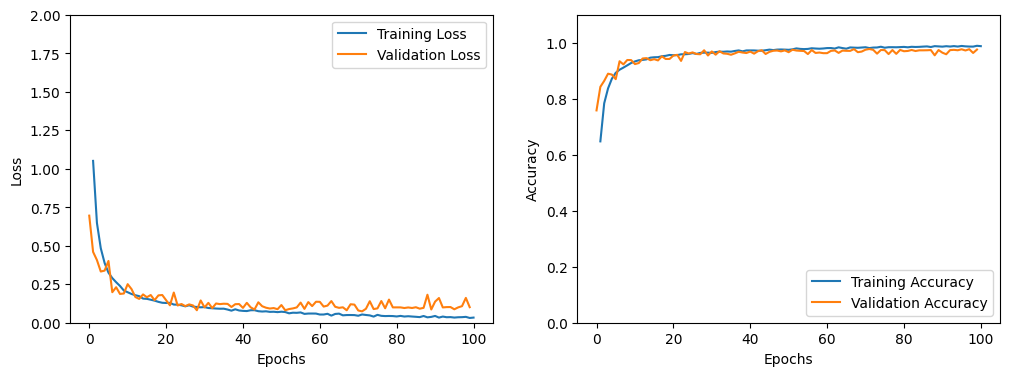

In [64]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [65]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 72) - Validation Loss: 0.072, Validation Accuracy: 0.980


In [66]:

start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.977
Test Time: 6.85 seconds ---> 0.11 minutes


In [67]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []
y_score = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(outputs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       450
           1       1.00      0.99      0.99       450
           2       0.95      0.97      0.96       450
           3       0.99      0.97      0.98       375
           4       0.98      0.99      0.99       375
           5       0.94      0.96      0.95       300
           6       0.96      0.95      0.96       375
           7       0.99      0.99      0.99       450
           8       0.97      0.98      0.98       375
           9       0.99      0.99      0.99       450

    accuracy                           0.98      4050
   macro avg       0.98      0.98      0.98      4050
weighted avg       0.98      0.98      0.98      4050

Class 0 Accuracy: 0.973
Class 1 Accuracy: 0.984
Class 2 Accuracy: 0.969
Class 3 Accuracy: 0.971
Class 4 Accuracy: 0.989
Class 5 Accuracy: 0.967
Class 6 Accuracy: 0.963
Class 7 Accuracy: 0.989
Class 8 Accuracy: 0.976
Cl

### Confusion Matrix

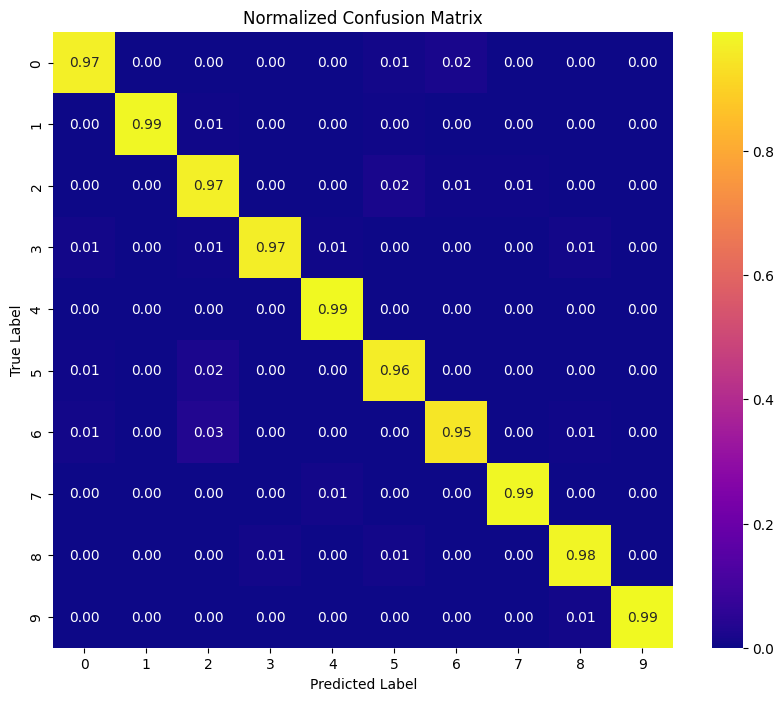

In [68]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='plasma', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()


### AUC, ROC Curve

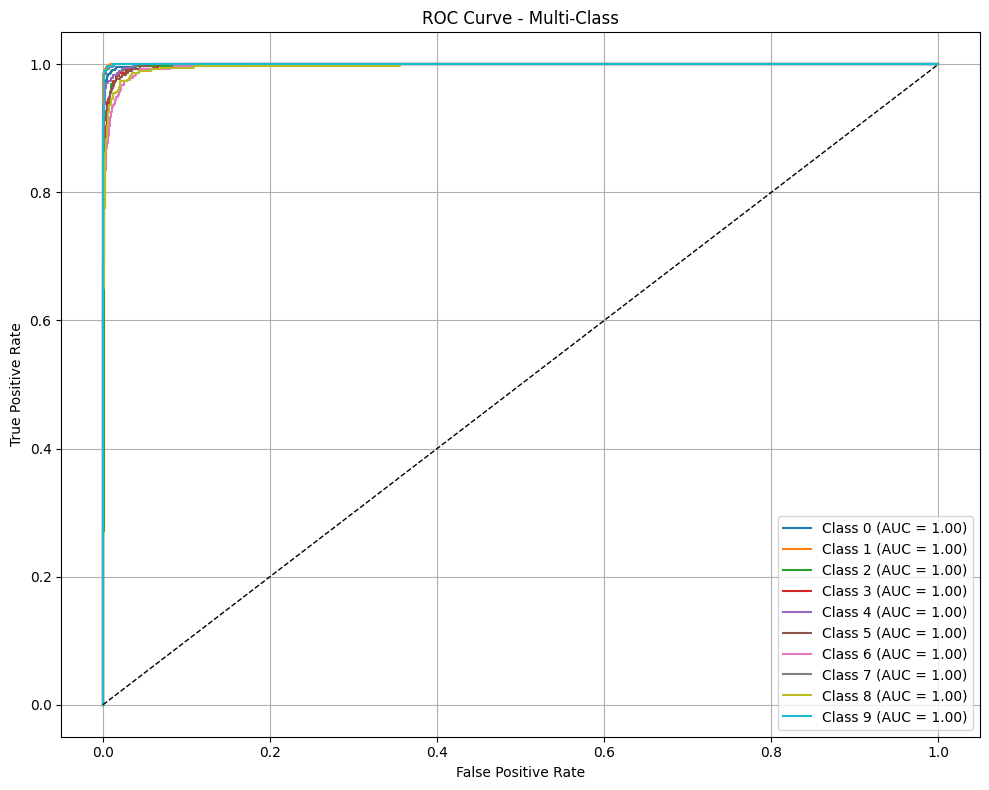

In [69]:
# Binarize labels
y_true_bin = label_binarize(y_true, classes=list(range(total_class)))

# Compute ROC and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(total_class):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(total_class):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()